# QSAR Modelling
**Authors**: Emmelie van der Veer, Lichelle Yeung, Ruben van Delden, Richard Salomons, Maximilian Falkner

This notebook describes the machine learning part of the identification of chemically diverse and novel tyrosine kinase inhibitors (TKIs) for treating chronic myeloid leukaemia (CML). Our work here includes QSAR modelling, virtual screening, clustering, similarity calculations and drug-likeness assessments.

## Install required modules, import libraries, set up directory

In [1]:
#Install required modules
!pip install rdkit
!pip install optuna

  Using cached rdkit-2024.3.5-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.9 kB)
Using cached rdkit-2024.3.5-cp311-cp311-manylinux_2_28_x86_64.whl (33.1 MB)
  Using cached optuna-4.0.0-py3-none-any.whl.metadata (16 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
Using cached optuna-4.0.0-py3-none-any.whl (362 kB)
Using cached colorlog-6.8.2-py3-none-any.whl (11 kB)


In [2]:
#Load required libraries

from pathlib import Path

import time
import math
import optuna
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import svm, metrics, clone
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, Draw, rdMolDescriptors, rdFingerprintGenerator, PandasTools, Descriptors, AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.ML.Cluster import Butina

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Silence some expected warnings
from warnings import filterwarnings
filterwarnings("ignore")

# Fix seed for reproducible results
import random
random.seed(5)
np.random.seed(5)

In [3]:
# Set up directory
import os
from pathlib import Path
HOMEDIR = Path.home()
folder_name = 'ACMDD'
folder_path = HOMEDIR/folder_name
os.chdir(folder_path)

# Check whether the directory is there
try:
    os.mkdir('Output')
except:
    print("Directory already exists")
os.chdir('Output')

Directory already exists


## QSAR Modelling

### Data preparation

#### Import ChEMBL data

Download activity data for ABL1 (CHEMBL1862) from the ChEMBL database (https://www.ebi.ac.uk/chembl/).

In [4]:
CHEMBLID = 'CHEMBL1862' 
FILENAME = '/home/jovyan/ACMDD/Data/ABL1.tsv'

data = pd.read_csv(FILENAME, sep='\t')

print("There are a total of {} datapoints in this set".format(len(data)))
data.head()

There are a total of 18331 datapoints in this set


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL1908391,MASITINIB,4.0,498.66,1.0,5.26,AB-1010,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,Kd,'=',...,SINGLE PROTEIN,CHEMBL1908390,1,Scientific Literature,Nat Biotechnol,2011.0,NaN,NaN,NaN,NaN
1,CHEMBL1908391,MASITINIB,4.0,498.66,1.0,5.26,AB-1010,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,Kd,'=',...,SINGLE PROTEIN,CHEMBL1908390,1,Scientific Literature,Nat Biotechnol,2011.0,NaN,NaN,NaN,NaN
2,CHEMBL608533,MIDOSTAURIN,4.0,570.65,2.0,5.91,PKC-412,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,Kd,'=',...,SINGLE PROTEIN,CHEMBL1908390,1,Scientific Literature,Nat Biotechnol,2011.0,NaN,NaN,NaN,NaN
3,CHEMBL502835,NINTEDANIB,4.0,539.64,1.0,3.62,BIBF-1120,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,Kd,'=',...,SINGLE PROTEIN,CHEMBL1908390,1,Scientific Literature,Nat Biotechnol,2011.0,NaN,NaN,NaN,NaN
4,CHEMBL1287853,FEDRATINIB,4.0,524.69,1.0,4.82,TG-101348,Cc1cnc(Nc2ccc(OCCN3CCCC3)cc2)nc1Nc1cccc(S(=O)(...,Kd,'=',...,SINGLE PROTEIN,CHEMBL1908390,1,Scientific Literature,Nat Biotechnol,2011.0,NaN,NaN,NaN,NaN


In [5]:
# Keep only relevant columns and rename columns
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data = pd_data.dropna() #drop compounds with no pChEMBL-values
pd_data.head()

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value
0,CHEMBL1908391,6.85,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,B,'=',140.0
1,CHEMBL1908391,8.22,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,B,'=',6.0
2,CHEMBL608533,5.25,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,B,'=',5600.0
3,CHEMBL502835,7.35,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,B,'=',45.0
4,CHEMBL1287853,7.25,Cc1cnc(Nc2ccc(OCCN3CCCC3)cc2)nc1Nc1cccc(S(=O)(...,B,'=',56.0


Based on "Beyond the hype: deep neural networks outperform established methods using a ChEMBL bioactivity benchmark set" (DOI: 10.1186/s13321-017-0232-0) an activity cut-off is set at pChEMBL > 6.5.

In [6]:
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 2964
Number of inactive compounds: 1539


In [7]:
# Drop functional assay data 
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 4254 activity points left


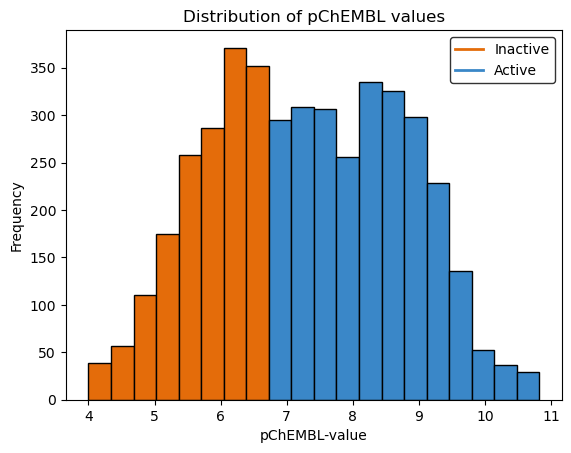

In [80]:
# Plot data distribution
threshold = 6.5
counts, bin_edges, patches = plt.hist(pd_data['pChEMBL_value'], bins=20, edgecolor='black')
for i, patch in enumerate(patches):
    if bin_edges[i] < threshold:
        patch.set_facecolor('#E46C0A')
    else:
        patch.set_facecolor('#3A87C8')

legend_elements = [
    Line2D([0], [0], color='#E46C0A', lw=2, label='Inactive'),
    Line2D([0], [0], color='#3A87C8', lw=2, label='Active')
]
legend = plt.legend(handles=legend_elements, loc='upper right')
legend.get_frame().set_edgecolor('black')

plt.xlabel('pChEMBL-value')
plt.ylabel('Frequency')
plt.title('Distribution of pChEMBL values')
plt.show()

In [8]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

#### Molecule encoding

In [9]:
def smiles_to_fp(smiles, method="morgan3", n_bits=2048):#change method and/or n_bits for model optimisation 
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganGenerator(radius=2, fpSize=n_bits).GetFingerprint(mol))
    if method == "morgan3":
        return np.array(GetMorganGenerator(radius=3, fpSize=n_bits).GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [10]:
#Calculate fingerprints for all datapoints
compound_df = pd_data.copy()
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[pd.isna(compound_df['fp'])].index, inplace=True)
compound_df.reset_index(drop=True, inplace = True)
compound_df.head(3)

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL1908391,6.85,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,B,'=',140.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,CHEMBL1908391,8.22,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,B,'=',6.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,CHEMBL608533,5.25,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,B,'=',5600.0,0.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Machine Learning

To make continuous bioactivity predictions, a regression model must be trained, validated and optimised.

In [11]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=5)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []
    R2_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
       
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        R2_per_fold.append(metrics.r2_score(test_y, test_results))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold, R2_per_fold, fold_model)

In this study predictive performance is assessed through the regression metrics R2 (the higher the better), mean absolute error (MAE, the lower the better) and root mean squared error (RMSE, the lower the better).

In [12]:
fingerprint_to_model = compound_df.fp.tolist() 
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=5)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 3403
Test data size: 851


#### Compare fingerprints

Optimal fingerpints are tested on the fast KNN regressor algorithm:

In [23]:
# MACCS keys
# Make sure to parse maccs, nBits = 166 under molecule encoding
regressor = KNeighborsRegressor()
MAE, RMSE, R2, trained_modelKNN = crossvalidation_reg(regressor, compound_df, n_folds=5)

# Output results
print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
f"R2: {np.mean(R2):.2f} \t"
f"and std : {np.std(R2):.2f} \n"
)

MAE: 0.65 	and std : 0.01 
RMSE: 0.88 	and std : 0.02 
R2: 0.62 	and std : 0.01 



In [31]:
# Morgan 2
# Make sure to parse morgan2, nBits = 1024 under molecule encoding
regressor = KNeighborsRegressor()
MAE, RMSE, R2, trained_modelKNN = crossvalidation_reg(regressor, compound_df, n_folds=5)

# Output results
print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
f"R2: {np.mean(R2):.2f} \t"
f"and std : {np.std(R2):.2f} \n"
)

MAE: 0.61 	and std : 0.02 
RMSE: 0.82 	and std : 0.02 
R2: 0.68 	and std : 0.02 



In [17]:
# Morgan 3
# Make sure to parse morgan3, nBits = 2048 under molecule encoding
regressor = KNeighborsRegressor()
MAE, RMSE, R2, trained_modelKNN = crossvalidation_reg(regressor, compound_df, n_folds=5)

# Output results
print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
f"R2: {np.mean(R2):.2f} \t"
f"and std : {np.std(R2):.2f} \n"
)

MAE: 0.61 	and std : 0.01 
RMSE: 0.81 	and std : 0.02 
R2: 0.68 	and std : 0.02 



Morgan 2 and Morgan 3 give a similar performance, therefore Morgan 3 was chosen during the follow-up.

#### Compare algorithms

In [13]:
# Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE, R2, trained_modelRF = crossvalidation_reg(regressor , compound_df, n_folds=5)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
f"R2: {np.mean(R2):.2f} \t"
f"and std : {np.std(R2):.2f} \n")

MAE: 0.58 	and std : 0.01 
RMSE: 0.77 	and std : 0.02 
R2: 0.71 	and std : 0.02 



In [20]:
# Train model with SupportVectorRegressor
regressor = SVR()
MAE, RMSE, R2, trained_modelSVR = crossvalidation_reg(regressor , compound_df, n_folds=5)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
f"R2: {np.mean(R2):.2f} \t"
f"and std : {np.std(R2):.2f} \n")

MAE: 0.56 	and std : 0.01 
RMSE: 0.76 	and std : 0.02 
R2: 0.72 	and std : 0.02 



In [21]:
# Train model with GradientBoostingRegressor
regressor = GradientBoostingRegressor()
MAE, RMSE, R2, trained_modelGBR = crossvalidation_reg(regressor , compound_df, n_folds=5)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
f"R2: {np.mean(R2):.2f} \t"
f"and std : {np.std(R2):.2f} \n")

MAE: 0.65 	and std : 0.02 
RMSE: 0.84 	and std : 0.02 
R2: 0.66 	and std : 0.02 



In [18]:
# Train model with Multi-layer Perceptron regressor
regressor = MLPRegressor()
MAE, RMSE, R2, trained_modelMLP = crossvalidation_reg(regressor, compound_df, n_folds=5)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
f"R2: {np.mean(R2):.2f} \t"
f"and std : {np.std(R2):.2f} \n"
)

MAE: 0.66 	and std : 0.02 
RMSE: 0.90 	and std : 0.05 
R2: 0.61 	and std : 0.05 



In [15]:
# Train model with k-nearest neighbors regressor
regressor = KNeighborsRegressor()
MAE, RMSE, R2, trained_modelKNN = crossvalidation_reg(regressor, compound_df, n_folds=5)

# Output results
print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
f"R2: {np.mean(R2):.2f} \t"
f"and std : {np.std(R2):.2f} \n"
)

MAE: 0.61 	and std : 0.01 
RMSE: 0.81 	and std : 0.02 
R2: 0.68 	and std : 0.02 



Similar regression metrics were found for the model trained with the random forest regressor and support vector regressor algorithm. Due to its robustness, the random forest regressor algorithm was chosen in the virtual screening step. 

#### Optimise model parameters

This code is provided to optimise the parameters of a regressor algorithm. Here, an example is given for the random forest regressor method. Because the cell takes a long time to run and model performance is not influenced greatly, it was chosen to proceed with the default parameters in the follow-up.

In [22]:
# Optimize RF model with Optuna

def objective(trial):
    # Hyperparameters to optimise (adjust to smaller or wider range)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Clone the existing model, updating the hyperparameters you want to tune
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=5 
    )

    # Evaluate the model with cross-validation
    score = cross_val_score(model, static_train_x, static_train_y, cv=5, scoring='r2').mean()
    return score

# Create the Optuna study and optimise hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) #Adjust for better results

# Retrieve best trial
print("Best hyperparameters: ", study.best_trial.params)

# Update existing model with the optimised hyperparameters
best_params = study.best_trial.params
trained_modelRF.set_params(**best_params)


[I 2024-09-24 09:02:36,336] A new study created in memory with name: no-name-5abb15b0-4a9c-48a9-a70f-3ecead47b0f5
[I 2024-09-24 09:08:11,174] Trial 0 finished with value: 0.7004746919175202 and parameters: {'n_estimators': 339, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7004746919175202.
[I 2024-09-24 09:15:09,958] Trial 1 finished with value: 0.699146828275154 and parameters: {'n_estimators': 408, 'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7004746919175202.
[I 2024-09-24 09:20:18,135] Trial 2 finished with value: 0.6600206616142995 and parameters: {'n_estimators': 424, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7004746919175202.
[I 2024-09-24 09:24:00,661] Trial 3 finished with value: 0.6397279300989819 and parameters: {'n_estimators': 352, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 7}. Best is trial 0 with valu

Best hyperparameters:  {'n_estimators': 363, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}


RandomForestRegressor(max_depth=19, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=363)

In [23]:
# Fit the model with the best hyperparameters
trained_modelRF.fit(static_train_x, static_train_y)

test_result = trained_modelRF.predict(static_test_x)

# Define regression metrics
R2 = r2_score(static_test_y, test_result)
RMSE = np.sqrt(mean_squared_error(static_test_y, test_result))
MAE = mean_absolute_error(static_test_y, test_result)

# Print the results
print(f"R²: {R2:.4f}")
print(f"RMSE: {RMSE:.4f}")
print(f"MAE: {MAE:.4f}")

R²: 0.6907
RMSE: 0.8013
MAE: 0.5846


Note that the amount of trials run here was only ten, which was not enough to identify a combination of parameters, which increased predictive performance with respect to the default parameters. Feel free to up the amount of trials and change the range of the parsed parameters to achieve improved performance.

## Virtual Screen

The screening set comprises a small set of compounds (181) with a minimum Tanimoto similarity of 0.6 to TKIs both approved and promising in clinical trials for the treatment of CML. All compounds have an in-stock status and were downloaded from the ZINC15 database (https://zinc15.docking.org/). 

In [14]:
# Import screening set from CSV file
screeningset = pd.read_csv('/home/jovyan/ACMDD/Data/virtualscreeningset.csv')

In [15]:
test_smiles = screeningset['smiles'].tolist()
fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_modelRF.predict(fps) #change trained_model to optimal one!!!
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

screeningset['predicted activity'] = predictions


SMILES, PREDICTION
COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCCN(C)CC4)c(OC)cc23)c(Cl)cc1Cl,9.51
COc1cc(Nc2c(C#N)cnc3cc(OCCCN(C)CCN(C)C)c(OC)cc23)c(Cl)cc1Cl,6.65
COc1cc(Nc2c(C#N)cnc3cc(OCCN4CCN(C)CC4)c(OC)cc23)c(Cl)cc1Cl,9.26
CCOc1cc2c(Nc3cc(OC)c(Cl)cc3Cl)c(C#N)cnc2cc1OCCCN1CCN(C)CC1,9.58
COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCCCC4)c(OC)cc23)c(Cl)cc1Cl,6.65
COc1cc(Nc2c(C#N)cnc3cc(OCCCN4C[C@H](C)N(C)[C@@H](C)C4)c(OC)cc23)c(Cl)cc1Cl,6.58
COc1cc(Nc2c(C#N)cnc3cc(OCCCN4C[C@H](C)N(C)[C@H](C)C4)c(OC)cc23)c(Cl)cc1Cl,6.58
COc1cc(Nc2c(C#N)cnc3cc(OCCCN4C[C@@H](C)N(C)[C@H](C)C4)c(OC)cc23)c(Cl)cc1Cl,6.58
COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCOCC4)c(OC)cc23)c(Cl)cc1Cl,6.68
COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCNCC4)c(OC)cc23)c(Cl)cc1Cl,6.67
COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(CCO)CC4)c(OC)cc23)c(Cl)cc1Cl,8.80
CCCN1CCN(CCCOc2cc3ncc(C#N)c(Nc4cc(OC)c(Cl)cc4Cl)c3cc2OC)CC1,8.89
CCN1CCN(CCCOc2cc3ncc(C#N)c(Nc4cc(OC)c(Cl)cc4Cl)c3cc2OC)CC1,8.89
COc1cc(Nc2c(C#N)cnc3cc(OCCCCN4CCOCC4)c(OC)cc23)c(Cl)cc1Cl,6.45
CCOc1cc2c(Nc3cc(OC)c(Cl)cc3Cl)c(C#N)cn

Plot the predicted bioactivity data:

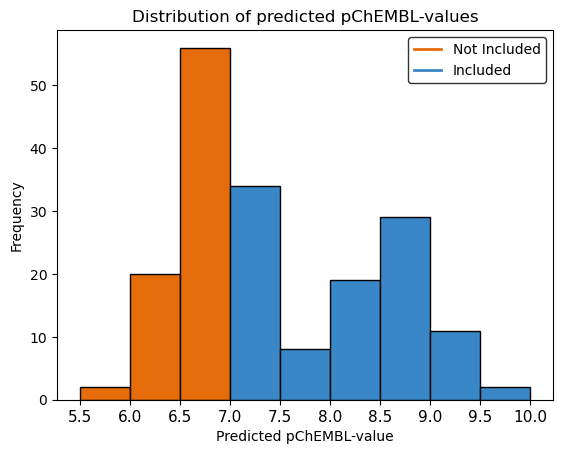

In [16]:
# Define activity cut-off
threshold = 7.0

# Set bin width
min_value = 5.5
max_value = 10
bins = np.arange(min_value, max_value + 0.5, 0.5) 

counts, bin_edges, patches = plt.hist(screeningset['predicted activity'], bins=bins, edgecolor='black')
for i, patch in enumerate(patches):
    if bin_edges[i] < threshold:
        patch.set_facecolor('#E46C0A')
    else:
        patch.set_facecolor('#3A87C8')

legend_elements = [
    Line2D([0], [0], color='#E46C0A', lw=2, label='Not Included'),
    Line2D([0], [0], color='#3A87C8', lw=2, label='Included')
]
legend = plt.legend(handles=legend_elements, loc='upper right')
legend.get_frame().set_edgecolor('black')

plt.xticks(np.arange(5.5, 10.5, 0.5))
plt.xticks(fontsize=11)
plt.xlabel('Predicted pChEMBL-value')
plt.ylabel('Frequency')
plt.title('Distribution of predicted pChEMBL-values')
plt.show()

Since it is aimed to identify novel TKIs, with a higher bioactivity than the first-line treatment Imatinib, only compounds with a predicted pChEMBL above 7.0 will be deemed virtual hits.

In [20]:
# Only compounds with a predicted pChEMBL > 7 are considered as hits
hits = screeningset[screeningset['predicted activity'] > 7].sort_values(by='predicted activity', ascending=False)
hits.reset_index(inplace = True, drop = True)
display(hits)

,zinc_id,smiles,predicted activity
0,ZINC000029124095,CCOc1cc2c(Nc3cc(OC)c(Cl)cc3Cl)c(C#N)cnc2cc1OCC...,9.579287
1,ZINC000023357818,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCCN(C)CC4)c(OC)c...,9.509611
2,ZINC000038662676,COc1cc(Nc2c(C#N)cnc3cc(OCCN4CCN(C)CC4)c(OC)cc2...,9.259009
3,ZINC000114369444,CCOc1cc2c(Nc3cc(OC)c(Cl)cc3Cl)c(C#N)cnc2cc1OCC...,9.228875
4,ZINC000029123923,COc1cc(Nc2c(C#N)cnc3cc(NCCCN4CCN(C)CC4)c(OC)cc...,9.224117
...,...,...,...
98,ZINC000220109908,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,7.111306
99,ZINC000065743052,Cc1ccc(NC(=O)c2cccc(CN3CCN(C)CC3)c2)cc1Nc1nccc...,7.029102
100,ZINC000053229152,Cc1ccc(C(=O)Nc2ccc(CN3CCN[C@@H](C)C3)c(C(F)(F)...,7.027890
101,ZINC000053229149,Cc1ccc(C(=O)Nc2ccc(CN3CCN[C@H](C)C3)c(C(F)(F)F...,7.027890


In [21]:
# Uncomment to save hits to a CSV file
#hits.to_csv('screening results.csv', index = False)
#print(f"Predictions saved to output folder")

Predictions saved to output folder


## Clustering

Since there is a high similarity between the virtual hits, chemical diversity can be introduced by clustering the compound based on Tanimoto similarity:

In [110]:
# Uncomment to import dataset form csv file
#hits = pd.read_csv('/home/jovyan/ACMDD/Output/Screening results.csv')

In [22]:
# Create molecules from SMILES and store in array
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, number, smiles in hits[["zinc_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), number))

In [23]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))

Number of compounds converted: 103
Fingerprint length per compound: 2048


In [24]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [25]:
def cluster_fingerprints(fingerprints, cutoff=0.4):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

Inspect figures to determine the best cut-off:

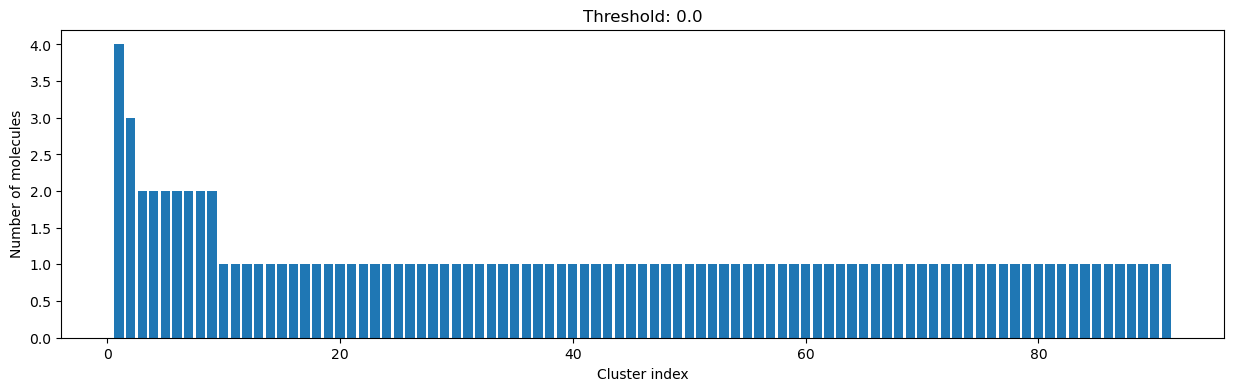

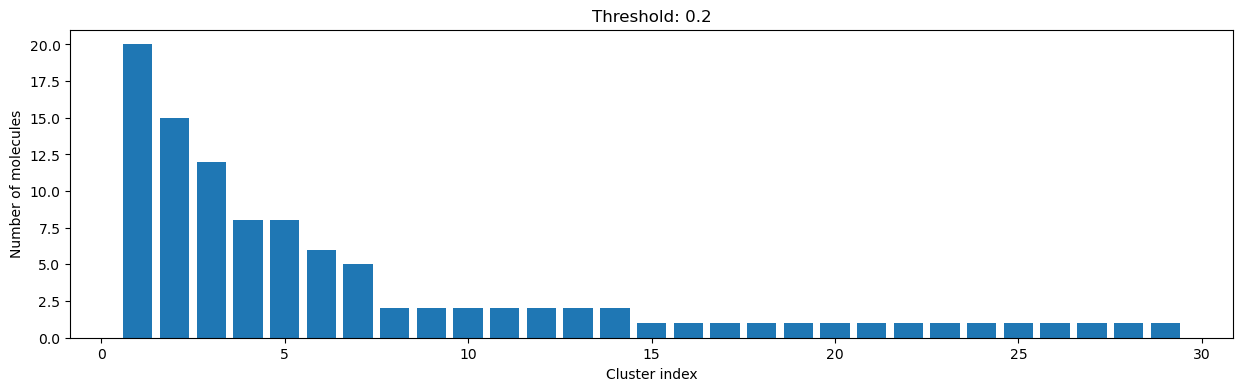

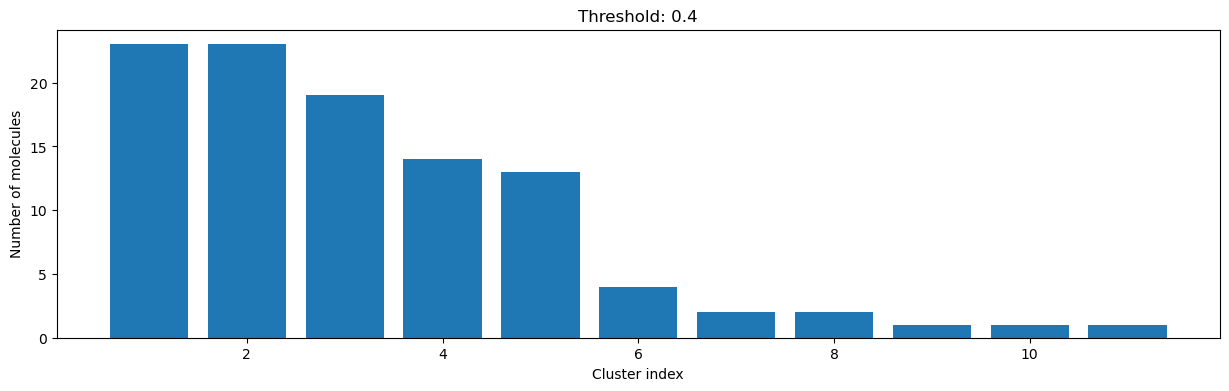

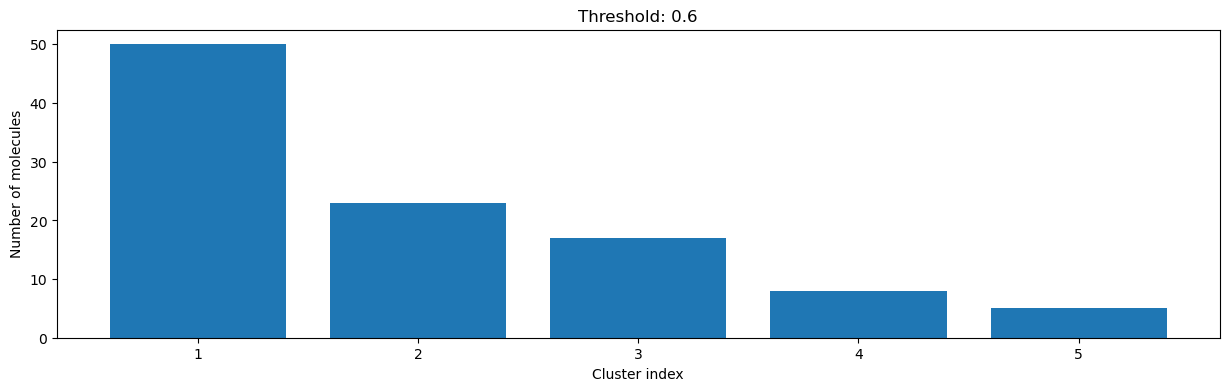

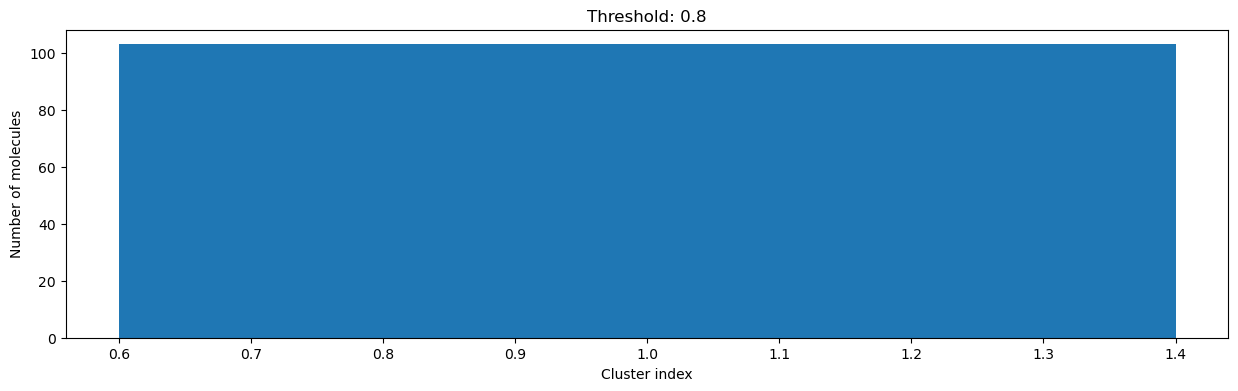

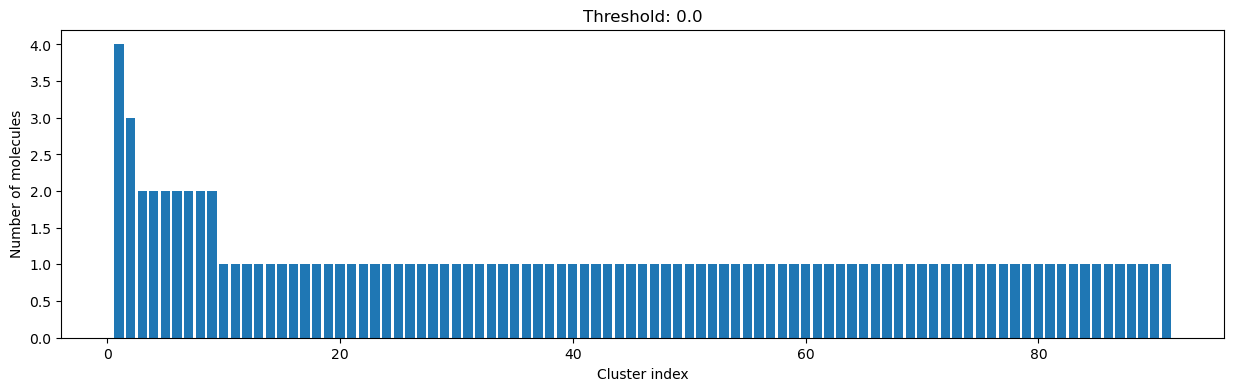

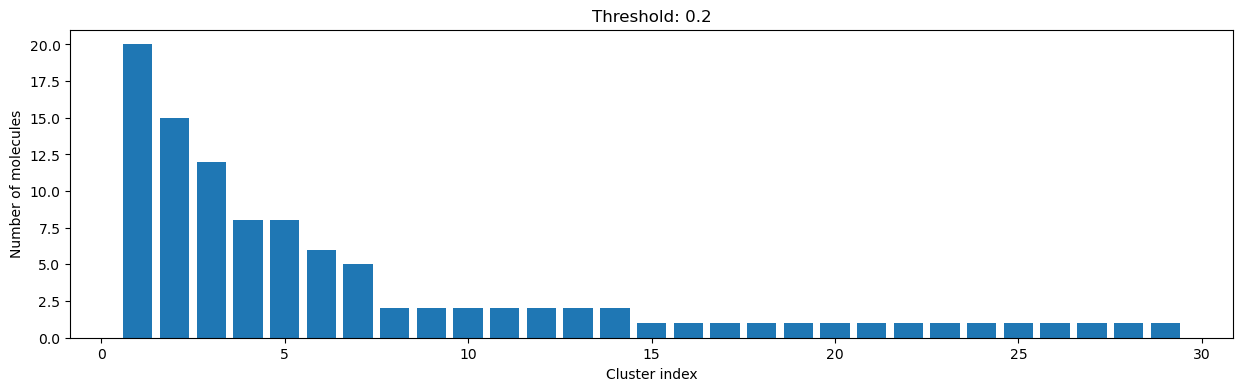

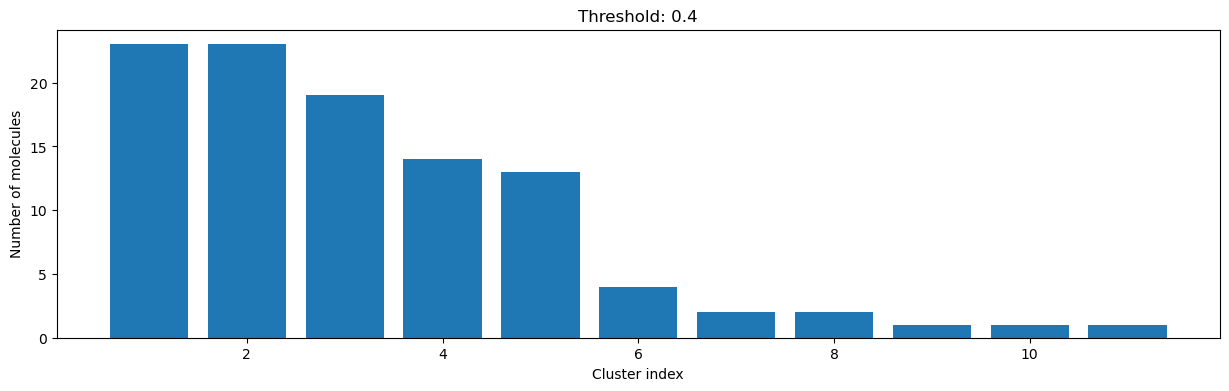

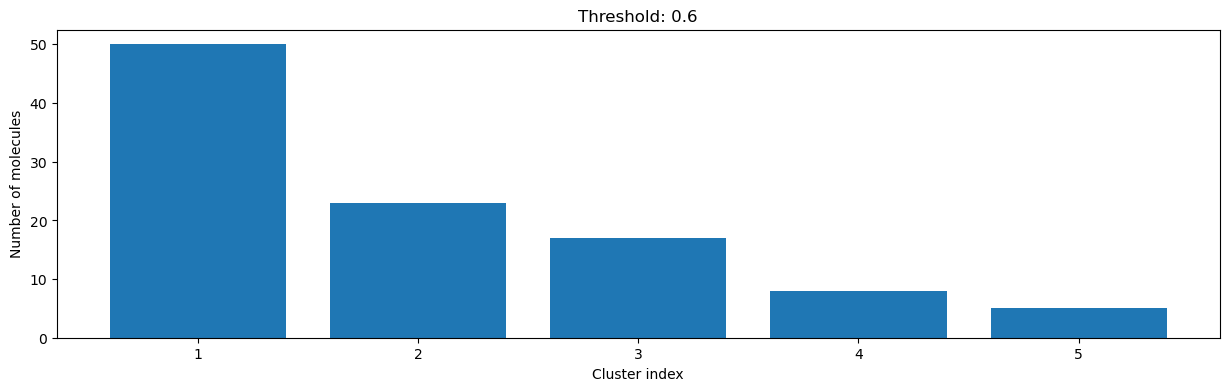

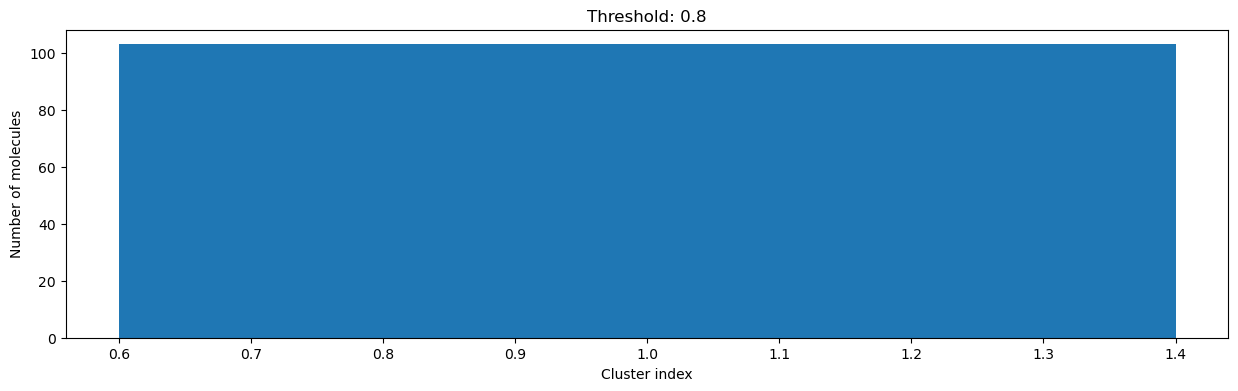

In [26]:
for cutoff in np.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

A cut-off of 0.4 seems to be best in this case, as clusters are not too big and the amount of singletons is reasonable. 

In [27]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.4)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  11
# clusters with only 1 compound:  3
# clusters with >5 compounds:  5
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


Number of clusters: 11 from 103 molecules at distance cut-off  0.400000
Number of molecules in largest cluster: 23
Similarity between two random points in same cluster: 0.94
Similarity between two random points in different cluster: 0.27


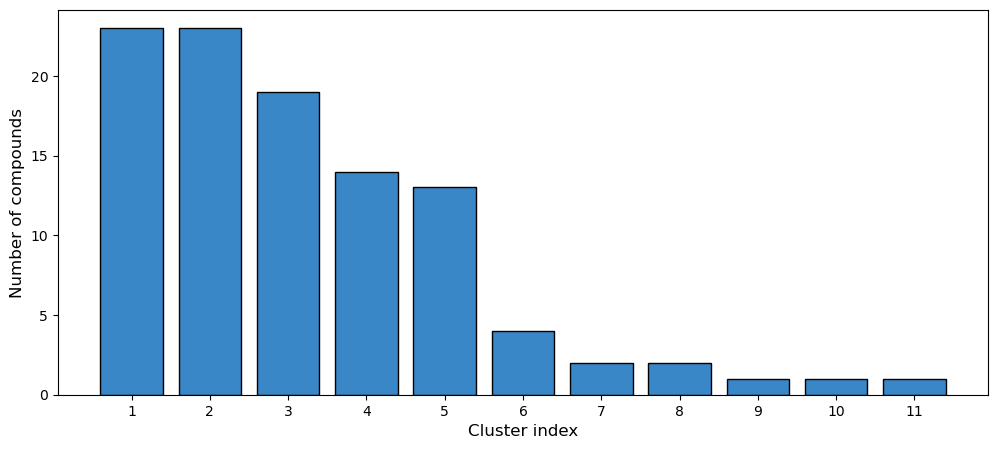

In [78]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlabel("Cluster index", fontsize = 12)
ax.set_ylabel("Number of compounds", fontsize = 12)
bar_colors = ['#3A87C8' for _ in range(len(clusters))]
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], color=bar_colors, edgecolor='black', lw=1);
cutoff = 0.4
plt.xticks(np.arange(1, 12, 1))

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff: 2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

Clusters centroids:


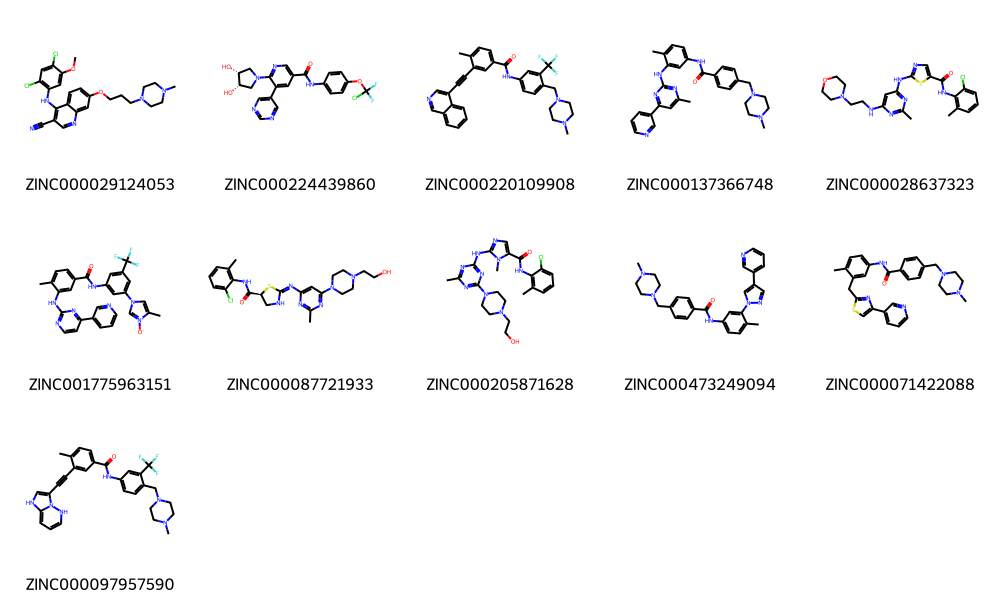

In [29]:
print("Clusters centroids:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(11)],
    legends=[compounds[clusters[i][0]][1] for i in range(11)],
    molsPerRow=5,
)

Each centroid is picked as the representative member of its respective cluster in the follow-up.

In [30]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))
# NBVAL_CHECK_OUTPUT

Number of cluster centers: 11


In [31]:
cluster_centers = pd.DataFrame(cluster_centers, columns=['RoMol','zinc_id'])
cluster_centers = pd.merge(cluster_centers, hits, on='zinc_id', how='inner')
cluster_centers = cluster_centers.drop('RoMol', axis=1)
display(cluster_centers)

,zinc_id,smiles,predicted activity
0,ZINC000029124053,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)ccc23)c...,8.044171
1,ZINC000224439860,O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1cnc(N2C[C@H](O)[C@...,8.259120
2,ZINC000220109908,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,7.111306
3,ZINC000137366748,Cc1cc(-c2cccnc2)nc(Nc2cc(NC(=O)c3ccc(CN4CCN(C)...,7.124237
4,ZINC000028637323,Cc1nc(NCCN2CCOCC2)cc(Nc2ncc(C(=O)Nc3c(C)cccc3C...,7.862444
5,ZINC001775963151,Cc1ccc(C(=O)Nc2cc(-n3cc(C)[n+]([O-])c3)cc(C(F)...,7.273745
6,ZINC000087721933,Cc1nc(/N=C2\NC[C@@H](C(=O)Nc3c(C)cccc3Cl)S2)cc...,8.102825
7,ZINC000205871628,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)n2C)nc(N2CCN(...,8.232315
8,ZINC000473249094,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1-n1cc(-...,7.207553
9,ZINC000071422088,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Cc1nc(-...,7.308700


In [32]:
# Uncomment to save cluster centers to a CSV file
#cluster_centers.to_csv('clustercenters.csv', index = False)
#print(f'Cluster centers saved to Output folder')

Cluster centers saved to Output folder


## Tanimoto to trainingset

The 11 compounds left are further assessed on chemical novelty. Since we want compounds that are different from the training set, the Tanimoto similarity to all training compounds will be calculated for each cluster center.

In [9]:
# Uncomment to import cluster centers from CSV file
cluster_centers = pd.read_csv('/home/jovyan/ACMDD/Output/clustercenters.csv')

# Import training data from csv file
trainingset = pd.read_csv('/home/jovyan/ACMDD/Data/trainingset.csv')

In [10]:
# Convert the SMILES strings to RDKit Mol objects
trainingset['mol'] = trainingset['Smiles'].apply(Chem.MolFromSmiles)
cluster_centers['mol'] = cluster_centers['smiles'].apply(Chem.MolFromSmiles)
 
# Number of compounds in each dataset
num_trainingset_compounds = len(trainingset)
num_clusters_compounds = len(cluster_centers)
 
# Initialize the distance matrix
tanimoto_distance_matrix = np.zeros((num_trainingset_compounds, num_clusters_compounds))

# Create a Morgan fingerprint generator
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)

# Calculate the Tanimoto distance between each pair of compounds
for i in range(num_trainingset_compounds):
    fp1 = morgan_gen.GetFingerprint(trainingset['mol'].iloc[i])  # Generate fingerprint for compound i
    for j in range(num_clusters_compounds):
        fp2 = morgan_gen.GetFingerprint(cluster_centers['mol'].iloc[j]) 
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        tanimoto_distance = 1 - tanimoto_similarity
        tanimoto_distance_matrix[i][j] = tanimoto_distance
 
# Convert the distance matrix to a pandas DataFrame
tanimoto_distance_df = pd.DataFrame(tanimoto_distance_matrix, index=trainingset['Smiles'], columns=cluster_centers['smiles'])
tanimoto_distance_df = tanimoto_distance_df.T

In [56]:
# Uncomment to save the distance matrix to a CSV file 
#tanimoto_distance_df.to_csv("tanimoto distance matrix.csv")
#rint(f'Tanimoto distance matrix saved to Output folder')

Tanimoto distance matrix saved to Output folder


In [11]:
# Get top 5 most similar compounds
top_5_similar = tanimoto_distance_df.apply(lambda row: row.nsmallest(5).index.tolist(), axis=1)
top_5_distances = tanimoto_distance_df.apply(lambda row: row.nsmallest(5).values.tolist(), axis=1)
 
# Prepare data for the DataFrame
data = {
    'Compound': tanimoto_distance_df.index,
    **{f'Similar_SMILES_{i+1}': [compounds[i] if len(compounds) > i else None for compounds in top_5_similar] for i in range(5)},
    **{f'Distance_{i+1}': [distances[i] if len(distances) > i else None for distances in top_5_distances] for i in range(5)},
}
 
# Convert to a DataFrame
top_5_similar_df = pd.DataFrame(data)
top_5_similar_df

,Compound,Similar_SMILES_1,Similar_SMILES_2,Similar_SMILES_3,Similar_SMILES_4,Similar_SMILES_5,Distance_1,Distance_2,Distance_3,Distance_4,Distance_5
0,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)ccc23)c...,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,COc1cc(Nc2c(C#N)cnc3cc(/C=C/CCN4CCN(C)CC4)c(OC...,COc1cc(Nc2c(C#N)cnc3cc(-c4coc(CN5CCN(C)CC5)c4)...,COc1cc(Nc2c(C#N)cnc3cc(-c4coc(CN5CCN(C)CC5)c4)...,COc1cc(Nc2c(C#N)cnc3cc(-c4coc(CN5CCN(c6ccccc6)...,0.313725,0.409091,0.417391,0.483333,0.567164
1,O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1cnc(N2C[C@H](O)[C@...,O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1cnc(N2C[C@H](O)[C@...,O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1cnc(N2C[C@@H](O)[C...,O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1cnc(N2CC(O)C2)c(-c...,O=C(Nc1ccc(OC(F)(F)F)cc1)c1cnc(N2C[C@@H](O)[C@...,NC1CN(c2ncc(C(=O)Nc3ccc(OC(F)(F)Cl)cc3)cc2-c2c...,0.000000,0.000000,0.135802,0.148148,0.158537
2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0.330357,0.333333,0.336283,0.342105,0.345133
3,Cc1cc(-c2cccnc2)nc(Nc2cc(NC(=O)c3ccc(CN4CCN(C)...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)c(Br)c2)cc1Nc1...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)c(F)c2)cc1Nc1n...,0.266667,0.293578,0.321101,0.446281,0.450820
4,Cc1nc(NCCN2CCOCC2)cc(Nc2ncc(C(=O)Nc3c(C)cccc3C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCNCC...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cc1nc(NCCO)cc(Nc2ncc(C(=O)Nc3c(Cl)ccnc3C)s2)n1,0.407080,0.412281,0.437500,0.451613,0.472727
5,Cc1ccc(C(=O)Nc2cc(-n3cc(C)[n+]([O-])c3)cc(C(F)...,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,Cc1cn(-c2cc(F)cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cc...,Cc1cc(NC(=O)c2ccc(C)c(Nc3nccc(-c4cccnc4)n3)c2)...,Cc1cn(-c2cccc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc...,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0.216216,0.369748,0.378151,0.430894,0.458647
6,Cc1nc(/N=C2\NC[C@@H](C(=O)Nc3c(C)cccc3Cl)S2)cc...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cc1nc(Nc2ncc(C(=O)Nc3ncccc3C)s2)cc(N2CCN(CCO)C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cncc3Cl)s2)cc(N2CCN(C...,0.536585,0.607692,0.638298,0.648855,0.654135
7,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)n2C)nc(N2CCN(...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cncc3Cl)s2)cc(N2CCN(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.561983,0.632812,0.661871,0.679389,0.686667
8,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1-n1cc(-...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc...,CN1CCN(Cc2ccc(C(=O)Nc3cccc(Nc4nccc(-c5cccnc5)n...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1C#Cc1cn...,0.452174,0.456897,0.470588,0.500000,0.537190
9,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Cc1nc(-...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc...,CN1CCN(Cc2ccc(C(=O)Nc3cccc(Nc4nccc(-c5cccnc5)n...,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1-c1ccc2...,0.360360,0.439655,0.458333,0.487179,0.545455


Because we are only interested in the similarity of the nearest training compound, irrelevant columns will be dropped and Tanimoto distances will be converted to similarities. 

In [12]:
clustercenters_filtered = pd.merge(cluster_centers, top_5_similar_df, left_on='smiles', right_on='Compound', how='inner')
columns_to_drop = ['mol','Similar_SMILES_2','Similar_SMILES_3','Similar_SMILES_4','Similar_SMILES_5',
                                           'Distance_2', 'Distance_3','Distance_4','Distance_5', 'Compound']
clustercenters_filtered = clustercenters_filtered.drop(columns=columns_to_drop)
clustercenters_filtered['Similarity'] = 1 - clustercenters_filtered['Distance_1']
clustercenters_filtered = clustercenters_filtered.rename(columns={'Distance_1': 'Tanimoto Distance', 'Similarity' : 'Tanimoto Similarity',
                                              'Similar_SMILES_1': 'Training SMILES'})
clustercenters_filtered = clustercenters_filtered.drop(columns= 'Tanimoto Distance')
clustercenters_filtered = pd.merge(clustercenters_filtered, trainingset, left_on = 'Training SMILES', right_on = 'Smiles')
clustercenters_filtered = clustercenters_filtered.rename(columns={'Molecule CHEMBL ID': 'ID Nearest Training Compound'})
display(clustercenters_filtered)

,zinc_id,smiles,predicted activity,Training SMILES,Tanimoto Similarity,Smiles,Molecule ChEMBL ID,mol
0,ZINC000029124053,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)ccc23)c...,8.044171,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,0.686275,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,CHEMBL288441,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4df50>
1,ZINC000224439860,O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1cnc(N2C[C@H](O)[C@...,8.259120,O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1cnc(N2C[C@H](O)[C@...,1.000000,O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1cnc(N2C[C@H](O)[C@...,CHEMBL3898258,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b75620>
2,ZINC000220109908,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,7.111306,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0.669643,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,CHEMBL1784626,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4a810>
3,ZINC000137366748,Cc1cc(-c2cccnc2)nc(Nc2cc(NC(=O)c3ccc(CN4CCN(C)...,7.124237,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.733333,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CHEMBL941,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b486d0>
4,ZINC000028637323,Cc1nc(NCCN2CCOCC2)cc(Nc2ncc(C(=O)Nc3c(C)cccc3C...,7.862444,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.592920,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,CHEMBL1421,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ae30>
5,ZINC001775963151,Cc1ccc(C(=O)Nc2cc(-n3cc(C)[n+]([O-])c3)cc(C(F)...,7.273745,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,0.783784,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,CHEMBL255863,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ace0>
6,ZINC000087721933,Cc1nc(/N=C2\NC[C@@H](C(=O)Nc3c(C)cccc3Cl)S2)cc...,8.102825,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.463415,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,CHEMBL1421,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ae30>
7,ZINC000205871628,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)n2C)nc(N2CCN(...,8.232315,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.438017,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,CHEMBL1421,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ae30>
8,ZINC000473249094,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1-n1cc(-...,7.207553,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.547826,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CHEMBL941,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b486d0>
9,ZINC000071422088,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Cc1nc(-...,7.308700,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,0.639640,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,CHEMBL1908391,<rdkit.Chem.rdchem.Mol object at 0x7f75d4ccf920>


To introduce novelty while keeping the applicability domain in mind, only compounds with a Tanimoto similarity of 0.5 - 0.9 are considered in the follow-up. For more information: (Bongers, B. J. et al. Proteochemometric Modeling Identifies Chemically Diverse Norepinephrine Transporter Inhibitors. Cite This: J. Chem. Inf. Model 63, 1745–1755 (2023).)

In [13]:
clustercenters_filtered = clustercenters_filtered.loc[(clustercenters_filtered['Tanimoto Similarity'] >= 0.5) & (clustercenters_filtered['Tanimoto Similarity'] <= 0.9)]
clustercenters_filtered.reset_index(inplace = True, drop = True)
display(clustercenters_filtered)

,zinc_id,smiles,predicted activity,Training SMILES,Tanimoto Similarity,Smiles,Molecule ChEMBL ID,mol
0,ZINC000029124053,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)ccc23)c...,8.044171,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,0.686275,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,CHEMBL288441,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4df50>
1,ZINC000220109908,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,7.111306,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0.669643,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,CHEMBL1784626,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4a810>
2,ZINC000137366748,Cc1cc(-c2cccnc2)nc(Nc2cc(NC(=O)c3ccc(CN4CCN(C)...,7.124237,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.733333,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CHEMBL941,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b486d0>
3,ZINC000028637323,Cc1nc(NCCN2CCOCC2)cc(Nc2ncc(C(=O)Nc3c(C)cccc3C...,7.862444,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.592920,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,CHEMBL1421,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ae30>
4,ZINC001775963151,Cc1ccc(C(=O)Nc2cc(-n3cc(C)[n+]([O-])c3)cc(C(F)...,7.273745,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,0.783784,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,CHEMBL255863,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ace0>
5,ZINC000473249094,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1-n1cc(-...,7.207553,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.547826,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CHEMBL941,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b486d0>
6,ZINC000071422088,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Cc1nc(-...,7.308700,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,0.639640,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,CHEMBL1908391,<rdkit.Chem.rdchem.Mol object at 0x7f75d4ccf920>
7,ZINC000097957590,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,7.342884,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0.643478,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,CHEMBL1784633,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b74190>


In [15]:
# Uncomment to save to a CSV file
#clustercenters_filtered.to_csv('filtered cluster centers.csv', index = False)
#print(f'Filtered cluster centers saved to Output folder')

Filtered cluster centers saved to Output folder


## Select Lead Compounds

As a final step, the chemically diverse and novel compounds will be assessed on their drug-likeness based on Lipinski's Ro5 (Lipinski, C. A., Lombardo, F., Dominy, B. W. & Feeney, P. J. Experimental and computational approaches to estimate solubility and permeability in drug discovery and development settings. Adv Drug Deliv Rev 23, 3–25 (1997).).

In [26]:
# Uncomment to import cluster centers from CSV file
#clustercenters_filtered = pd.read_csv('/home/jovyan/ACMDD/Output/novel compounds.csv')

In [16]:
# Generate molecular structure from smiles
PandasTools.AddMoleculeColumnToFrame(clustercenters_filtered, "smiles")
clustercenters_filtered.head()

,zinc_id,smiles,predicted activity,Training SMILES,Tanimoto Similarity,Smiles,Molecule ChEMBL ID,mol,ROMol
0,ZINC000029124053,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)ccc23)c...,8.044171,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,0.686275,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,CHEMBL288441,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4df50>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a8350>
1,ZINC000220109908,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,7.111306,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0.669643,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,CHEMBL1784626,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4a810>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a8820>
2,ZINC000137366748,Cc1cc(-c2cccnc2)nc(Nc2cc(NC(=O)c3ccc(CN4CCN(C)...,7.124237,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.733333,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CHEMBL941,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b486d0>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48aa3b0>
3,ZINC000028637323,Cc1nc(NCCN2CCOCC2)cc(Nc2ncc(C(=O)Nc3c(C)cccc3C...,7.862444,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.592920,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,CHEMBL1421,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ae30>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a8dd0>
4,ZINC001775963151,Cc1ccc(C(=O)Nc2cc(-n3cc(C)[n+]([O-])c3)cc(C(F)...,7.273745,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,0.783784,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,CHEMBL255863,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ace0>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a83c0>


In [17]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

In [20]:
# Calculate physicochemical properties from RoMol objects
ro5_properties = clustercenters_filtered["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,499.154180,7,1,5.18178,True
1,542.229346,4,1,5.96152,False
2,507.274659,7,2,4.89874,True
3,487.155722,9,3,3.94334,True
4,545.178708,7,2,5.59424,False


In [21]:
clustercenters_filtered = pd.concat([clustercenters_filtered, ro5_properties], axis=1)
clustercenters_filtered.head()

,zinc_id,smiles,predicted activity,Training SMILES,Tanimoto Similarity,Smiles,Molecule ChEMBL ID,mol,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,ZINC000029124053,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)ccc23)c...,8.044171,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,0.686275,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,CHEMBL288441,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4df50>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a8350>,499.154180,7,1,5.18178,True
1,ZINC000220109908,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,7.111306,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0.669643,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,CHEMBL1784626,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4a810>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a8820>,542.229346,4,1,5.96152,False
2,ZINC000137366748,Cc1cc(-c2cccnc2)nc(Nc2cc(NC(=O)c3ccc(CN4CCN(C)...,7.124237,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.733333,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CHEMBL941,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b486d0>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48aa3b0>,507.274659,7,2,4.89874,True
3,ZINC000028637323,Cc1nc(NCCN2CCOCC2)cc(Nc2ncc(C(=O)Nc3c(C)cccc3C...,7.862444,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.592920,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,CHEMBL1421,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ae30>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a8dd0>,487.155722,9,3,3.94334,True
4,ZINC001775963151,Cc1ccc(C(=O)Nc2cc(-n3cc(C)[n+]([O-])c3)cc(C(F)...,7.273745,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,0.783784,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,CHEMBL255863,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ace0>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a83c0>,545.178708,7,2,5.59424,False


In [22]:
# Asses which compounds display lead-likeness
molecules_ro5_fulfilled = clustercenters_filtered[clustercenters_filtered["ro5_fulfilled"]]
molecules_ro5_violated = clustercenters_filtered[~clustercenters_filtered["ro5_fulfilled"]]

print(f"# all compounds: {clustercenters_filtered.shape[0]}")
print(f"# compounds compliant with the Ro5: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")

# all compounds: 8
# compounds compliant with the Ro5: 6
# compounds not compliant with the Ro5: 2


Only compounds that adhere to the Ro5 will be included in the final set of TKI candidate compounds.

In [23]:
molecules_ro5_fulfilled = molecules_ro5_fulfilled.sort_values(by=['predicted activity'], ascending=False)
molecules_ro5_fulfilled.reset_index(inplace = True, drop = True)
display(molecules_ro5_fulfilled)

,zinc_id,smiles,predicted activity,Training SMILES,Tanimoto Similarity,Smiles,Molecule ChEMBL ID,mol,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,ZINC000029124053,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)ccc23)c...,8.044171,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,0.686275,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,CHEMBL288441,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4df50>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a8350>,499.154180,7,1,5.18178,True
1,ZINC000028637323,Cc1nc(NCCN2CCOCC2)cc(Nc2ncc(C(=O)Nc3c(C)cccc3C...,7.862444,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.592920,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,CHEMBL1421,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b4ae30>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a8dd0>,487.155722,9,3,3.94334,True
2,ZINC000097957590,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,7.342884,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0.643478,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,CHEMBL1784633,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b74190>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a8580>,534.235494,6,3,3.98492,True
3,ZINC000071422088,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Cc1nc(-...,7.308700,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,0.639640,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,CHEMBL1908391,<rdkit.Chem.rdchem.Mol object at 0x7f75d4ccf920>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48aa180>,497.224932,6,1,5.10402,True
4,ZINC000473249094,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1-n1cc(-...,7.207553,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.547826,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CHEMBL941,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b486d0>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48a9850>,466.248110,6,1,4.24242,True
5,ZINC000137366748,Cc1cc(-c2cccnc2)nc(Nc2cc(NC(=O)c3ccc(CN4CCN(C)...,7.124237,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.733333,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,CHEMBL941,<rdkit.Chem.rdchem.Mol object at 0x7f75d4b486d0>,<rdkit.Chem.rdchem.Mol object at 0x7f75d48aa3b0>,507.274659,7,2,4.89874,True


In [24]:
# Uncomment to save lead compounds to CSV file
#molecules_ro5_fulfilled.to_csv("lead compounds.csv")
#print(f'Lead compounds saved to output folder')

Lead compounds saved to output folder


##### Radar Plot

Plot the physicochemical properties of the final set of compounds:

In [33]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

In [34]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,498.548849,22.471923
n_hba,6.833333,1.169045
n_hbd,1.833333,0.983192
logp,4.559203,0.567301


In [35]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

In [36]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [40]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    #y = y.append(y.iloc[0])

    first_row = y.iloc[[y.index.get_loc('molecular_weight')]]
    y = pd.concat([y, first_row])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 5, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("rule of five area", "mean + std", "mean - std", "mean")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In [41]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

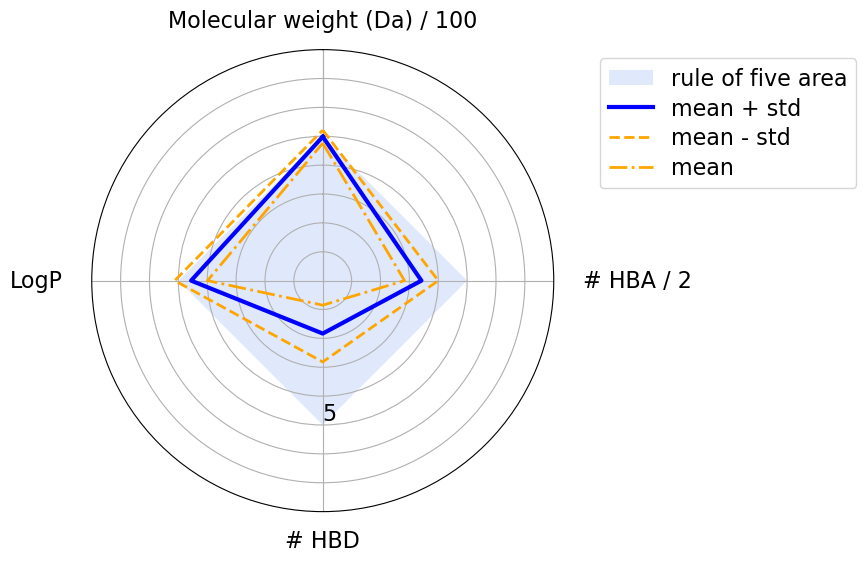

In [42]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

## What is next?

To gain more insights into the protein-ligand interactions, which cause a high affinity for ABL1, the TKI candidates can be docked into the ATP-binding site of the kinase. Please refer to the second notebook “Docking” for the structure-based part of this project. 